In [2]:
import pandas as pd
import numpy as np
from Bio.Seq import Seq
from Bio import SeqIO
#from Bio.Alphabet import IUPAC
import sys
# import pyensembl
import os
#https://towardsdatascience.com/a-simple-guide-to-command-line-arguments-with-argparse-6824c30ab1c3
import warnings
warnings.filterwarnings("ignore")
from Bio.SeqUtils import seq3

import glob
import protfasta
import Levenshtein
import seaborn as sns
import requests
import matplotlib.pyplot as plt

In [3]:
# Plan:
# Import zoonomia raw file
# Use ensembl API to get nt per position
# Import Bed file per cds
# Translate DNA sequence from zoonomia
# Check if translated sequence matches known TF seq
# Match up

---

In [4]:
# Output with PhyloP Scores

In [5]:
zoonomia_bed = pd.read_csv("../soto_analysis/raw_files/zoonomia_all_TF_cds.bed", sep = "\t", header = None)
zoonomia_bed[1] = zoonomia_bed[1].astype(int)
zoonomia_bed[2] = zoonomia_bed[2].astype(int)
#zoonomia_bed[3] = zoonomia_bed[3].astype(int)
#zoonomia_bed[4] = zoonomia_bed[4].astype(int)
zoonomia_bed

,0,1,2,3
0,3,142005441,142005442,6.299
1,3,142005442,142005443,6.324
2,3,142005443,142005444,6.324
3,3,142005444,142005445,6.324
4,3,142005445,142005446,8.746
...,...,...,...,...
2751585,19,7075739,7075740,-0.412
2751586,19,7075740,7075741,1.754
2751587,19,7075741,7075742,0.061
2751588,19,7075742,7075743,2.618


In [6]:
# Input, to use to get DNA sequences
zoonomia_input = pd.read_csv("../data/TF_all_cds.bed", sep = "\t", header = None)
zoonomia_input

,0,1,2,3
0,chr19,11977038,11977165,ENST00000358987
1,chr19,11965209,11965212,ENST00000358987
2,chr19,11977371,11977432,ENST00000358987
3,chr19,11978116,11979110,ENST00000358987
4,chr1,165444845,165444894,ENST00000359842
...,...,...,...,...
9517,chrX,49034134,49034252,ENST00000315869
9518,chrX,49033726,49033783,ENST00000315869
9519,chrX,49033465,49033541,ENST00000315869
9520,chrX,49031397,49031545,ENST00000315869


In [7]:
# Loading in zoonomia input parts to ucsc table browser
bed_dna  = []

dna_outputs = glob.glob("../data/TF_all_cds_split/genomic_pt_*")

for z in dna_outputs:
    seq_dict = protfasta.read_fasta(z, expect_unique_header = False, duplicate_sequence_action='ignore', duplicate_record_action='ignore')#.reset_index()
    df = pd.DataFrame({"id" : seq_dict.keys(), "seq": seq_dict.values()})
    bed_dna.append(df)

bed_dna = pd.concat(bed_dna)
bed_dna

,id,seq
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG
1,hg38_refGene_NM_001253_1 range=chr6:44390268-4...,GATGAAATTCTGAAAGCAGCGGTAATGAAATATGGGAAAAATCAGT...
2,hg38_refGene_NM_001253_2 range=chr6:44392667-4...,GTATGAATGGCTGGATCCAAGCATTAAGAAGACAGAATGGTCCAGA...
3,hg38_refGene_NM_001253_3 range=chr6:44393446-4...,GGATAAAGCTGCCCAAAGAGACAATGAAGAGGAAACAACAGATGAT...
4,hg38_refGene_NM_001253_4 range=chr6:44396341-4...,ATGAACTTGAGATGCTTTCTGAAGCCAGAGCCCGCTTGGCTAATAC...
...,...,...
1485,hg38_refGene_NM_001282142_3 range=chrX:4903413...,CTGCCTGTGTCAGGGAATCTGCTTGATGTGTACAGTAGTCAAGGCG...
1486,hg38_refGene_NM_001282142_4 range=chrX:4903372...,AGACCGAGGCAAAGGCCCTTTTGAAGGAACGGCAGAAGAAAGACAA...
1487,hg38_refGene_NM_001282142_5 range=chrX:4903346...,TTGAGCGTCGCAGGCGATTCAACATTAACGACAGGATCAAGGAACT...
1488,hg38_refGene_NM_001282142_6 range=chrX:4903139...,GGAGATGCGCTGGAACAAGGGCACCATCCTGAAGGCCTCTGTGGAT...


In [8]:
bed_dna["range"] = bed_dna["id"].str.extract('range=(.*?) ')
bed_dna

,id,seq,range
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868
1,hg38_refGene_NM_001253_1 range=chr6:44390268-4...,GATGAAATTCTGAAAGCAGCGGTAATGAAATATGGGAAAAATCAGT...,chr6:44390268-44390371
2,hg38_refGene_NM_001253_2 range=chr6:44392667-4...,GTATGAATGGCTGGATCCAAGCATTAAGAAGACAGAATGGTCCAGA...,chr6:44392667-44392828
3,hg38_refGene_NM_001253_3 range=chr6:44393446-4...,GGATAAAGCTGCCCAAAGAGACAATGAAGAGGAAACAACAGATGAT...,chr6:44393446-44393573
4,hg38_refGene_NM_001253_4 range=chr6:44396341-4...,ATGAACTTGAGATGCTTTCTGAAGCCAGAGCCCGCTTGGCTAATAC...,chr6:44396341-44396440
...,...,...,...
1485,hg38_refGene_NM_001282142_3 range=chrX:4903413...,CTGCCTGTGTCAGGGAATCTGCTTGATGTGTACAGTAGTCAAGGCG...,chrX:49034134-49034251
1486,hg38_refGene_NM_001282142_4 range=chrX:4903372...,AGACCGAGGCAAAGGCCCTTTTGAAGGAACGGCAGAAGAAAGACAA...,chrX:49033726-49033782
1487,hg38_refGene_NM_001282142_5 range=chrX:4903346...,TTGAGCGTCGCAGGCGATTCAACATTAACGACAGGATCAAGGAACT...,chrX:49033465-49033540
1488,hg38_refGene_NM_001282142_6 range=chrX:4903139...,GGAGATGCGCTGGAACAAGGGCACCATCCTGAAGGCCTCTGTGGAT...,chrX:49031397-49031544


In [9]:
bed_dna["chr"] = bed_dna["range"].str.extract(r'chr(.*?):')
bed_dna

,id,seq,range,chr
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6
1,hg38_refGene_NM_001253_1 range=chr6:44390268-4...,GATGAAATTCTGAAAGCAGCGGTAATGAAATATGGGAAAAATCAGT...,chr6:44390268-44390371,6
2,hg38_refGene_NM_001253_2 range=chr6:44392667-4...,GTATGAATGGCTGGATCCAAGCATTAAGAAGACAGAATGGTCCAGA...,chr6:44392667-44392828,6
3,hg38_refGene_NM_001253_3 range=chr6:44393446-4...,GGATAAAGCTGCCCAAAGAGACAATGAAGAGGAAACAACAGATGAT...,chr6:44393446-44393573,6
4,hg38_refGene_NM_001253_4 range=chr6:44396341-4...,ATGAACTTGAGATGCTTTCTGAAGCCAGAGCCCGCTTGGCTAATAC...,chr6:44396341-44396440,6
...,...,...,...,...
1485,hg38_refGene_NM_001282142_3 range=chrX:4903413...,CTGCCTGTGTCAGGGAATCTGCTTGATGTGTACAGTAGTCAAGGCG...,chrX:49034134-49034251,X
1486,hg38_refGene_NM_001282142_4 range=chrX:4903372...,AGACCGAGGCAAAGGCCCTTTTGAAGGAACGGCAGAAGAAAGACAA...,chrX:49033726-49033782,X
1487,hg38_refGene_NM_001282142_5 range=chrX:4903346...,TTGAGCGTCGCAGGCGATTCAACATTAACGACAGGATCAAGGAACT...,chrX:49033465-49033540,X
1488,hg38_refGene_NM_001282142_6 range=chrX:4903139...,GGAGATGCGCTGGAACAAGGGCACCATCCTGAAGGCCTCTGTGGAT...,chrX:49031397-49031544,X


In [10]:
bed_dna["start"] = bed_dna["range"].str.extract(r':(.*?)-').astype(int)
bed_dna["end"] = bed_dna["range"].str.extract(r'-(.*)').astype(int)
bed_dna

,id,seq,range,chr,start,end
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868
1,hg38_refGene_NM_001253_1 range=chr6:44390268-4...,GATGAAATTCTGAAAGCAGCGGTAATGAAATATGGGAAAAATCAGT...,chr6:44390268-44390371,6,44390268,44390371
2,hg38_refGene_NM_001253_2 range=chr6:44392667-4...,GTATGAATGGCTGGATCCAAGCATTAAGAAGACAGAATGGTCCAGA...,chr6:44392667-44392828,6,44392667,44392828
3,hg38_refGene_NM_001253_3 range=chr6:44393446-4...,GGATAAAGCTGCCCAAAGAGACAATGAAGAGGAAACAACAGATGAT...,chr6:44393446-44393573,6,44393446,44393573
4,hg38_refGene_NM_001253_4 range=chr6:44396341-4...,ATGAACTTGAGATGCTTTCTGAAGCCAGAGCCCGCTTGGCTAATAC...,chr6:44396341-44396440,6,44396341,44396440
...,...,...,...,...,...,...
1485,hg38_refGene_NM_001282142_3 range=chrX:4903413...,CTGCCTGTGTCAGGGAATCTGCTTGATGTGTACAGTAGTCAAGGCG...,chrX:49034134-49034251,X,49034134,49034251
1486,hg38_refGene_NM_001282142_4 range=chrX:4903372...,AGACCGAGGCAAAGGCCCTTTTGAAGGAACGGCAGAAGAAAGACAA...,chrX:49033726-49033782,X,49033726,49033782
1487,hg38_refGene_NM_001282142_5 range=chrX:4903346...,TTGAGCGTCGCAGGCGATTCAACATTAACGACAGGATCAAGGAACT...,chrX:49033465-49033540,X,49033465,49033540
1488,hg38_refGene_NM_001282142_6 range=chrX:4903139...,GGAGATGCGCTGGAACAAGGGCACCATCCTGAAGGCCTCTGTGGAT...,chrX:49031397-49031544,X,49031397,49031544


In [11]:
bed_dna = bed_dna.drop_duplicates(["seq"])
bed_dna

,id,seq,range,chr,start,end
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868
1,hg38_refGene_NM_001253_1 range=chr6:44390268-4...,GATGAAATTCTGAAAGCAGCGGTAATGAAATATGGGAAAAATCAGT...,chr6:44390268-44390371,6,44390268,44390371
2,hg38_refGene_NM_001253_2 range=chr6:44392667-4...,GTATGAATGGCTGGATCCAAGCATTAAGAAGACAGAATGGTCCAGA...,chr6:44392667-44392828,6,44392667,44392828
3,hg38_refGene_NM_001253_3 range=chr6:44393446-4...,GGATAAAGCTGCCCAAAGAGACAATGAAGAGGAAACAACAGATGAT...,chr6:44393446-44393573,6,44393446,44393573
4,hg38_refGene_NM_001253_4 range=chr6:44396341-4...,ATGAACTTGAGATGCTTTCTGAAGCCAGAGCCCGCTTGGCTAATAC...,chr6:44396341-44396440,6,44396341,44396440
...,...,...,...,...,...,...
1478,hg38_refGene_NM_006521_6 range=chrX:49033726-4...,AGACCGAGGCAAAGGCCCTTTTGAAGGAACGGCAGAAGAAAGACAA...,chrX:49033726-49033782,X,49033726,49033782
1479,hg38_refGene_NM_006521_7 range=chrX:49033465-4...,TTGAGCGTCGCAGGCGATTCAACATTAACGACAGGATCAAGGAACT...,chrX:49033465-49033540,X,49033465,49033540
1480,hg38_refGene_NM_006521_8 range=chrX:49031397-4...,GGAGATGCGCTGGAACAAGGGCACCATCCTGAAGGCCTCTGTGGAT...,chrX:49031397-49031544,X,49031397,49031544
1481,hg38_refGene_NM_006521_9 range=chrX:49030158-4...,GAACTAGAACTGCAGGCCCAGATCCATGGCCTGCCAGTACCTCCCA...,chrX:49030158-49030601,X,49030158,49030601


In [12]:
np.arange(5, 1 - 1, -1)

array([5, 4, 3, 2, 1])

In [13]:
bed_dna

,id,seq,range,chr,start,end
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868
1,hg38_refGene_NM_001253_1 range=chr6:44390268-4...,GATGAAATTCTGAAAGCAGCGGTAATGAAATATGGGAAAAATCAGT...,chr6:44390268-44390371,6,44390268,44390371
2,hg38_refGene_NM_001253_2 range=chr6:44392667-4...,GTATGAATGGCTGGATCCAAGCATTAAGAAGACAGAATGGTCCAGA...,chr6:44392667-44392828,6,44392667,44392828
3,hg38_refGene_NM_001253_3 range=chr6:44393446-4...,GGATAAAGCTGCCCAAAGAGACAATGAAGAGGAAACAACAGATGAT...,chr6:44393446-44393573,6,44393446,44393573
4,hg38_refGene_NM_001253_4 range=chr6:44396341-4...,ATGAACTTGAGATGCTTTCTGAAGCCAGAGCCCGCTTGGCTAATAC...,chr6:44396341-44396440,6,44396341,44396440
...,...,...,...,...,...,...
1478,hg38_refGene_NM_006521_6 range=chrX:49033726-4...,AGACCGAGGCAAAGGCCCTTTTGAAGGAACGGCAGAAGAAAGACAA...,chrX:49033726-49033782,X,49033726,49033782
1479,hg38_refGene_NM_006521_7 range=chrX:49033465-4...,TTGAGCGTCGCAGGCGATTCAACATTAACGACAGGATCAAGGAACT...,chrX:49033465-49033540,X,49033465,49033540
1480,hg38_refGene_NM_006521_8 range=chrX:49031397-4...,GGAGATGCGCTGGAACAAGGGCACCATCCTGAAGGCCTCTGTGGAT...,chrX:49031397-49031544,X,49031397,49031544
1481,hg38_refGene_NM_006521_9 range=chrX:49030158-4...,GAACTAGAACTGCAGGCCCAGATCCATGGCCTGCCAGTACCTCCCA...,chrX:49030158-49030601,X,49030158,49030601


In [14]:
start = 1
end = 5
np.arange(end - 1, start - 2, -1)

array([4, 3, 2, 1, 0])

In [15]:
start = 1
end = 5
np.arange(start - 1, end)

array([0, 1, 2, 3, 4])

In [16]:
bed_dna["seq_split"] = bed_dna["seq"].str.split("").str[1:-1]
bed_dna["strand"] = bed_dna['id'].str.extract(r'strand=(.)')

new_starts = []
for i in range(len(bed_dna)):
    s = bed_dna['start'].iloc[i]
    e = bed_dna['end'].iloc[i]
    if bed_dna['strand'].iloc[i] == "+":
        new_starts.append(np.arange(s - 1, e)) # Because switching from position to bed format
    else:
        new_starts.append(np.arange(e - 1, s - 2, -1))
bed_dna["new_start"] = new_starts
bed_dna

,id,seq,range,chr,start,end,seq_split,strand,new_start
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868,"[A, T, G, C, C, T, C, G, A, A, T, T, A, T, G, ...",+,"[44387823, 44387824, 44387825, 44387826, 44387..."
1,hg38_refGene_NM_001253_1 range=chr6:44390268-4...,GATGAAATTCTGAAAGCAGCGGTAATGAAATATGGGAAAAATCAGT...,chr6:44390268-44390371,6,44390268,44390371,"[G, A, T, G, A, A, A, T, T, C, T, G, A, A, A, ...",+,"[44390267, 44390268, 44390269, 44390270, 44390..."
2,hg38_refGene_NM_001253_2 range=chr6:44392667-4...,GTATGAATGGCTGGATCCAAGCATTAAGAAGACAGAATGGTCCAGA...,chr6:44392667-44392828,6,44392667,44392828,"[G, T, A, T, G, A, A, T, G, G, C, T, G, G, A, ...",+,"[44392666, 44392667, 44392668, 44392669, 44392..."
3,hg38_refGene_NM_001253_3 range=chr6:44393446-4...,GGATAAAGCTGCCCAAAGAGACAATGAAGAGGAAACAACAGATGAT...,chr6:44393446-44393573,6,44393446,44393573,"[G, G, A, T, A, A, A, G, C, T, G, C, C, C, A, ...",+,"[44393445, 44393446, 44393447, 44393448, 44393..."
4,hg38_refGene_NM_001253_4 range=chr6:44396341-4...,ATGAACTTGAGATGCTTTCTGAAGCCAGAGCCCGCTTGGCTAATAC...,chr6:44396341-44396440,6,44396341,44396440,"[A, T, G, A, A, C, T, T, G, A, G, A, T, G, C, ...",+,"[44396340, 44396341, 44396342, 44396343, 44396..."
...,...,...,...,...,...,...,...,...,...
1478,hg38_refGene_NM_006521_6 range=chrX:49033726-4...,AGACCGAGGCAAAGGCCCTTTTGAAGGAACGGCAGAAGAAAGACAA...,chrX:49033726-49033782,X,49033726,49033782,"[A, G, A, C, C, G, A, G, G, C, A, A, A, G, G, ...",-,"[49033781, 49033780, 49033779, 49033778, 49033..."
1479,hg38_refGene_NM_006521_7 range=chrX:49033465-4...,TTGAGCGTCGCAGGCGATTCAACATTAACGACAGGATCAAGGAACT...,chrX:49033465-49033540,X,49033465,49033540,"[T, T, G, A, G, C, G, T, C, G, C, A, G, G, C, ...",-,"[49033539, 49033538, 49033537, 49033536, 49033..."
1480,hg38_refGene_NM_006521_8 range=chrX:49031397-4...,GGAGATGCGCTGGAACAAGGGCACCATCCTGAAGGCCTCTGTGGAT...,chrX:49031397-49031544,X,49031397,49031544,"[G, G, A, G, A, T, G, C, G, C, T, G, G, A, A, ...",-,"[49031543, 49031542, 49031541, 49031540, 49031..."
1481,hg38_refGene_NM_006521_9 range=chrX:49030158-4...,GAACTAGAACTGCAGGCCCAGATCCATGGCCTGCCAGTACCTCCCA...,chrX:49030158-49030601,X,49030158,49030601,"[G, A, A, C, T, A, G, A, A, C, T, G, C, A, G, ...",-,"[49030600, 49030599, 49030598, 49030597, 49030..."


In [19]:
# return_dna_seq(19, 6047406, 6047496)

In [20]:
bed_dna[bed_dna["strand"] == "-"].iloc[0]

id           hg38_refGene_NM_134433_0 range=chr19:6047407-6...
seq          ATGCAGAATTCCGAGGGTGGAGCGGATTCGCCAGCGTCCGTGGCTC...
range                                    chr19:6047407-6047496
chr                                                         19
start                                                  6047407
end                                                    6047496
seq_split    [A, T, G, C, A, G, A, A, T, T, C, C, G, A, G, ...
strand                                                       -
new_start    [6047495, 6047494, 6047493, 6047492, 6047491, ...
Name: 16, dtype: object

In [21]:
bed_dna[bed_dna["strand"] == "-"].iloc[0]["seq"]

'ATGCAGAATTCCGAGGGTGGAGCGGATTCGCCAGCGTCCGTGGCTCTGCGTCCCTCGGCGGCAGCCCCGCCTGTGCCAGCCTCCCCGCAG'

In [22]:
bed_dna[bed_dna["strand"] == "-"].iloc[0]["new_start"]

array([6047495, 6047494, 6047493, 6047492, 6047491, 6047490, 6047489,
       6047488, 6047487, 6047486, 6047485, 6047484, 6047483, 6047482,
       6047481, 6047480, 6047479, 6047478, 6047477, 6047476, 6047475,
       6047474, 6047473, 6047472, 6047471, 6047470, 6047469, 6047468,
       6047467, 6047466, 6047465, 6047464, 6047463, 6047462, 6047461,
       6047460, 6047459, 6047458, 6047457, 6047456, 6047455, 6047454,
       6047453, 6047452, 6047451, 6047450, 6047449, 6047448, 6047447,
       6047446, 6047445, 6047444, 6047443, 6047442, 6047441, 6047440,
       6047439, 6047438, 6047437, 6047436, 6047435, 6047434, 6047433,
       6047432, 6047431, 6047430, 6047429, 6047428, 6047427, 6047426,
       6047425, 6047424, 6047423, 6047422, 6047421, 6047420, 6047419,
       6047418, 6047417, 6047416, 6047415, 6047414, 6047413, 6047412,
       6047411, 6047410, 6047409, 6047408, 6047407, 6047406])

In [23]:
bed_dna[bed_dna["strand"] == "+"].iloc[0]

id           hg38_refGene_NM_001253_0 range=chr6:44387824-4...
seq              ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG
range                                   chr6:44387824-44387868
chr                                                          6
start                                                 44387824
end                                                   44387868
seq_split    [A, T, G, C, C, T, C, G, A, A, T, T, A, T, G, ...
strand                                                       +
new_start    [44387823, 44387824, 44387825, 44387826, 44387...
Name: 0, dtype: object

In [24]:
bed_dna[bed_dna["strand"] == "+"].iloc[0]

id           hg38_refGene_NM_001253_0 range=chr6:44387824-4...
seq              ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG
range                                   chr6:44387824-44387868
chr                                                          6
start                                                 44387824
end                                                   44387868
seq_split    [A, T, G, C, C, T, C, G, A, A, T, T, A, T, G, ...
strand                                                       +
new_start    [44387823, 44387824, 44387825, 44387826, 44387...
Name: 0, dtype: object

In [25]:
bed_dna["new_start"].iloc[0]

array([44387823, 44387824, 44387825, 44387826, 44387827, 44387828,
       44387829, 44387830, 44387831, 44387832, 44387833, 44387834,
       44387835, 44387836, 44387837, 44387838, 44387839, 44387840,
       44387841, 44387842, 44387843, 44387844, 44387845, 44387846,
       44387847, 44387848, 44387849, 44387850, 44387851, 44387852,
       44387853, 44387854, 44387855, 44387856, 44387857, 44387858,
       44387859, 44387860, 44387861, 44387862, 44387863, 44387864,
       44387865, 44387866, 44387867])

In [26]:
bed_dna["seq_split"].iloc[0]

['A',
 'T',
 'G',
 'C',
 'C',
 'T',
 'C',
 'G',
 'A',
 'A',
 'T',
 'T',
 'A',
 'T',
 'G',
 'A',
 'T',
 'C',
 'A',
 'A',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'C',
 'G',
 'T',
 'A',
 'T',
 'G',
 'G',
 'A',
 'G',
 'G',
 'A',
 'A',
 'T',
 'A',
 'C',
 'C',
 'G',
 'A',
 'G']

In [27]:
bed_dna_exploded = bed_dna.explode(["seq_split", "new_start"])
bed_dna_exploded = bed_dna_exploded.reset_index(drop = True)
bed_dna_exploded

,id,seq,range,chr,start,end,seq_split,strand,new_start
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868,A,+,44387823
1,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868,T,+,44387824
2,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868,G,+,44387825
3,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868,C,+,44387826
4,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868,C,+,44387827
...,...,...,...,...,...,...,...,...,...
3261004,hg38_refGene_NM_001282142_0 range=chrX:4903910...,ATGTCGTCATCTTCTTCATCGAGGGTCTTGCTGCGGCAGCAGCTAA...,chrX:49039107-49039325,X,49039107,49039325,T,-,49039110
3261005,hg38_refGene_NM_001282142_0 range=chrX:4903910...,ATGTCGTCATCTTCTTCATCGAGGGTCTTGCTGCGGCAGCAGCTAA...,chrX:49039107-49039325,X,49039107,49039325,C,-,49039109
3261006,hg38_refGene_NM_001282142_0 range=chrX:4903910...,ATGTCGTCATCTTCTTCATCGAGGGTCTTGCTGCGGCAGCAGCTAA...,chrX:49039107-49039325,X,49039107,49039325,A,-,49039108
3261007,hg38_refGene_NM_001282142_0 range=chrX:4903910...,ATGTCGTCATCTTCTTCATCGAGGGTCTTGCTGCGGCAGCAGCTAA...,chrX:49039107-49039325,X,49039107,49039325,A,-,49039107


In [28]:
# bed_dna_exploded_pos_strand = bed_dna_exploded[~bed_dna_exploded["id"].str.contains("strand=-")]
# bed_dna_exploded_pos_strand = bed_dna_exploded_pos_strand.reset_index(drop = True)
# bed_dna_exploded_pos_strand

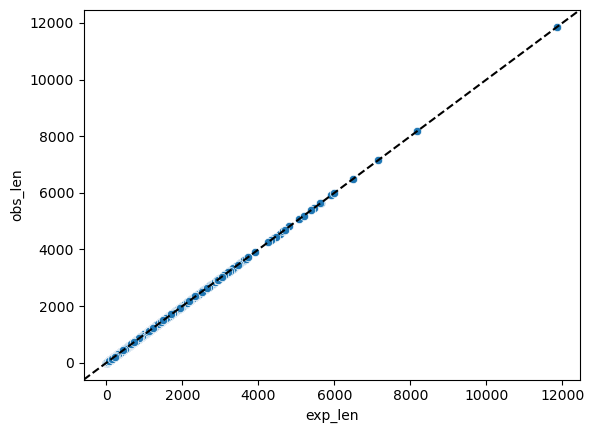

In [29]:
# Checking work - looks good now
bed_dna['exp_len'] = [len(_) for _ in bed_dna["new_start"]]
bed_dna['obs_len'] = bed_dna["seq"].str.len()
g = sns.scatterplot(data = bed_dna, x = "exp_len", y = "obs_len")
plt.axline((0, 0), slope=1, color='k', ls='--')

In [30]:
bed_dna

,id,seq,range,chr,start,end,seq_split,strand,new_start,exp_len,obs_len
0,hg38_refGene_NM_001253_0 range=chr6:44387824-4...,ATGCCTCGAATTATGATCAAGGGGGGCGTATGGAGGAATACCGAG,chr6:44387824-44387868,6,44387824,44387868,"[A, T, G, C, C, T, C, G, A, A, T, T, A, T, G, ...",+,"[44387823, 44387824, 44387825, 44387826, 44387...",45,45
1,hg38_refGene_NM_001253_1 range=chr6:44390268-4...,GATGAAATTCTGAAAGCAGCGGTAATGAAATATGGGAAAAATCAGT...,chr6:44390268-44390371,6,44390268,44390371,"[G, A, T, G, A, A, A, T, T, C, T, G, A, A, A, ...",+,"[44390267, 44390268, 44390269, 44390270, 44390...",104,104
2,hg38_refGene_NM_001253_2 range=chr6:44392667-4...,GTATGAATGGCTGGATCCAAGCATTAAGAAGACAGAATGGTCCAGA...,chr6:44392667-44392828,6,44392667,44392828,"[G, T, A, T, G, A, A, T, G, G, C, T, G, G, A, ...",+,"[44392666, 44392667, 44392668, 44392669, 44392...",162,162
3,hg38_refGene_NM_001253_3 range=chr6:44393446-4...,GGATAAAGCTGCCCAAAGAGACAATGAAGAGGAAACAACAGATGAT...,chr6:44393446-44393573,6,44393446,44393573,"[G, G, A, T, A, A, A, G, C, T, G, C, C, C, A, ...",+,"[44393445, 44393446, 44393447, 44393448, 44393...",128,128
4,hg38_refGene_NM_001253_4 range=chr6:44396341-4...,ATGAACTTGAGATGCTTTCTGAAGCCAGAGCCCGCTTGGCTAATAC...,chr6:44396341-44396440,6,44396341,44396440,"[A, T, G, A, A, C, T, T, G, A, G, A, T, G, C, ...",+,"[44396340, 44396341, 44396342, 44396343, 44396...",100,100
...,...,...,...,...,...,...,...,...,...,...,...
1478,hg38_refGene_NM_006521_6 range=chrX:49033726-4...,AGACCGAGGCAAAGGCCCTTTTGAAGGAACGGCAGAAGAAAGACAA...,chrX:49033726-49033782,X,49033726,49033782,"[A, G, A, C, C, G, A, G, G, C, A, A, A, G, G, ...",-,"[49033781, 49033780, 49033779, 49033778, 49033...",57,57
1479,hg38_refGene_NM_006521_7 range=chrX:49033465-4...,TTGAGCGTCGCAGGCGATTCAACATTAACGACAGGATCAAGGAACT...,chrX:49033465-49033540,X,49033465,49033540,"[T, T, G, A, G, C, G, T, C, G, C, A, G, G, C, ...",-,"[49033539, 49033538, 49033537, 49033536, 49033...",76,76
1480,hg38_refGene_NM_006521_8 range=chrX:49031397-4...,GGAGATGCGCTGGAACAAGGGCACCATCCTGAAGGCCTCTGTGGAT...,chrX:49031397-49031544,X,49031397,49031544,"[G, G, A, G, A, T, G, C, G, C, T, G, G, A, A, ...",-,"[49031543, 49031542, 49031541, 49031540, 49031...",148,148
1481,hg38_refGene_NM_006521_9 range=chrX:49030158-4...,GAACTAGAACTGCAGGCCCAGATCCATGGCCTGCCAGTACCTCCCA...,chrX:49030158-49030601,X,49030158,49030601,"[G, A, A, C, T, A, G, A, A, C, T, G, C, A, G, ...",-,"[49030600, 49030599, 49030598, 49030597, 49030...",444,444


In [31]:
bed_dna_exploded["new_end"] = bed_dna_exploded["new_start"] + 1
expected_bases = bed_dna_exploded[["chr", "new_start", "new_end", "seq_split", "strand"]]
expected_bases

,chr,new_start,new_end,seq_split,strand
0,6,44387823,44387824,A,+
1,6,44387824,44387825,T,+
2,6,44387825,44387826,G,+
3,6,44387826,44387827,C,+
4,6,44387827,44387828,C,+
...,...,...,...,...,...
3261004,X,49039110,49039111,T,-
3261005,X,49039109,49039110,C,-
3261006,X,49039108,49039109,A,-
3261007,X,49039107,49039108,A,-


In [32]:
# # Helper function to make API call

# def return_dna_seq(chr_num, start, end):
#     # Define the endpoint and parameters
#     url = "http://api.genome.ucsc.edu/getData/sequence"
#     params = {
#         "genome" : "hg38",
#         "chrom": "chr" + str(chr_num),
#         "start": start, # So the genome browser is actually 1 off??
#         "end": end
#     }
    
#     # Make the GET request to the UCSC Genome Browser API
#     response = requests.get(url, params=params)
    
#     # Check if the request was successful (status code 200)
#     if response.status_code == 200:
#         # Parse the JSON response (assuming the response is in JSON format)
#         dna_sequence = response.json()
#         # Print the DNA sequence
#         #print('done')
#         return dna_sequence['dna']
#     else:
#         print(str(chr_num))
#         print(start)
#         print(end)
#         print(f"Error: {response.status_code}")
#         return "!"


In [33]:
# # Only differences in upper vs lower case sometimes - Everything else checks out!
# for i in range(10):
#     row = expected_bases.iloc[np.random.choice(expected_bases.index)]
#     exp_base = return_dna_seq(row["chr"], row["new_start"], row["new_end"])
#     if row["seq_split"] != exp_base:
#         print("ERROR")
#         print(row)
#         print("expected: " + exp_base)
#         print("got: " + row["seq_split"])
#         print()

In [34]:
expected_bases["chr"] = expected_bases["chr"].astype(str)
zoonomia_bed[0] = zoonomia_bed[0].astype(str)
zoonomia_bed[1] = zoonomia_bed[1].astype(int)
zoonomia_bed[2] = zoonomia_bed[2].astype(int)

In [35]:
expected_bases = expected_bases.drop_duplicates()
expected_bases

,chr,new_start,new_end,seq_split,strand
0,6,44387823,44387824,A,+
1,6,44387824,44387825,T,+
2,6,44387825,44387826,G,+
3,6,44387826,44387827,C,+
4,6,44387827,44387828,C,+
...,...,...,...,...,...
3260785,X,49030161,49030162,C,-
3260786,X,49030160,49030161,C,-
3260787,X,49030159,49030160,T,-
3260788,X,49030158,49030159,G,-


In [36]:
#Convert everything to pos strand
new_nts = []

for i in range(len(expected_bases)):
    convert_dict = {'A' : 'T',
                    'T' : 'A',
                    'G' : 'C', 
                    'C' : 'G'}
    nt = expected_bases["seq_split"].iloc[i]
    if expected_bases["strand"].iloc[i] == "-":
        new_nts.append(convert_dict[nt])
    else:
        new_nts.append(nt)

expected_bases["pos_strand_nt"] = new_nts
expected_bases

,chr,new_start,new_end,seq_split,strand,pos_strand_nt
0,6,44387823,44387824,A,+,A
1,6,44387824,44387825,T,+,T
2,6,44387825,44387826,G,+,G
3,6,44387826,44387827,C,+,C
4,6,44387827,44387828,C,+,C
...,...,...,...,...,...,...
3260785,X,49030161,49030162,C,-,G
3260786,X,49030160,49030161,C,-,G
3260787,X,49030159,49030160,T,-,A
3260788,X,49030158,49030159,G,-,C


In [37]:
expected_bases = expected_bases.drop_duplicates(subset = ["chr", "new_start", "pos_strand_nt"])
expected_bases

,chr,new_start,new_end,seq_split,strand,pos_strand_nt
0,6,44387823,44387824,A,+,A
1,6,44387824,44387825,T,+,T
2,6,44387825,44387826,G,+,G
3,6,44387826,44387827,C,+,C
4,6,44387827,44387828,C,+,C
...,...,...,...,...,...,...
3260785,X,49030161,49030162,C,-,G
3260786,X,49030160,49030161,C,-,G
3260787,X,49030159,49030160,T,-,A
3260788,X,49030158,49030159,G,-,C


In [38]:
pd.merge(zoonomia_bed, expected_bases, left_on = [0, 1, 2], right_on = ["chr", "new_start", "new_end"], how = "left").dropna()

,0,1,2,3,chr,new_start,new_end,seq_split,strand,pos_strand_nt
0,3,142005441,142005442,6.299,3,142005441,142005442,T,-,A
1,3,142005442,142005443,6.324,3,142005442,142005443,A,-,T
2,3,142005443,142005444,6.324,3,142005443,142005444,A,-,T
3,3,142005444,142005445,6.324,3,142005444,142005445,A,-,T
4,3,142005445,142005446,8.746,3,142005445,142005446,C,-,G
...,...,...,...,...,...,...,...,...,...,...
2751584,19,7075738,7075739,2.672,19,7075738,7075739,T,+,T
2751585,19,7075739,7075740,-0.412,19,7075739,7075740,A,+,A
2751586,19,7075740,7075741,1.754,19,7075740,7075741,A,+,A
2751587,19,7075741,7075742,0.061,19,7075741,7075742,A,+,A


In [39]:
#Nulls may not actually be in CDS?
zoonomia_bed_with_bases = pd.merge(zoonomia_bed, expected_bases, left_on = [0, 1, 2], right_on = ["chr", "new_start", "new_end"], how = "left")
zoonomia_bed_with_bases

,0,1,2,3,chr,new_start,new_end,seq_split,strand,pos_strand_nt
0,3,142005441,142005442,6.299,3,142005441,142005442,T,-,A
1,3,142005442,142005443,6.324,3,142005442,142005443,A,-,T
2,3,142005443,142005444,6.324,3,142005443,142005444,A,-,T
3,3,142005444,142005445,6.324,3,142005444,142005445,A,-,T
4,3,142005445,142005446,8.746,3,142005445,142005446,C,-,G
...,...,...,...,...,...,...,...,...,...,...
2751585,19,7075739,7075740,-0.412,19,7075739,7075740,A,+,A
2751586,19,7075740,7075741,1.754,19,7075740,7075741,A,+,A
2751587,19,7075741,7075742,0.061,19,7075741,7075742,A,+,A
2751588,19,7075742,7075743,2.618,19,7075742,7075743,G,+,G


In [40]:
zoonomia_bed_with_bases[[0, 1, "pos_strand_nt"]].value_counts().iloc[:10]

0   1         pos_strand_nt
1   999059    C                1
20  62861127  C                1
    62861129  G                1
    62861130  C                1
    62861131  T                1
    62861132  T                1
    62861133  G                1
    62861134  G                1
    62861135  C                1
    62861136  C                1
Name: count, dtype: int64

---

In [41]:
TFs_tbl = pd.read_csv("../soto_analysis/outputs/all_TFs_table_proteins.txt", sep = "\t")
TFs_tbl

,Unnamed: 0,1,2,uniprotID,ENSG,ENST,DBD_coords,AD_coords,RD_coords,Bif_coords,length
0,0,NaN,NaN,A6NJG6,NaN,ENST00000334384,79-135,142-315,NaN,NaN,1
1,1,NaN,NaN,A8MTJ6,NaN,ENST00000428390,145-234,369-420,NaN,NaN,1
2,2,NaN,NaN,A8MYZ6,NaN,ENST00000641094,89-178,382-491,NaN,NaN,1
3,3,NaN,NaN,A8MZ59,NaN,ENST00000640845,31-65,92-181,NaN,NaN,1
4,4,NaN,NaN,O00321,NaN,ENST00000403402,242-321,1-162,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
441,441,NaN,NaN,Q9Y5R6,NaN,ENST00000382276,72-118,172-251,NaN,NaN,1
442,442,NaN,NaN,Q9Y5W3,NaN,ENST00000248071,"272-296,302-326,332-354",1-89,NaN,NaN,1
443,443,NaN,NaN,Q9Y692,NaN,ENST00000294409,89-165,422-573,NaN,NaN,1
444,444,NaN,NaN,Q9Y6Q9,NaN,ENST00000371998,31-83,621-1424,NaN,NaN,1


In [42]:
lambert_TFs = pd.read_csv("../output/lambert_TFs_10-21-24_with_DBD_coords.csv", index_col = 0)
lambert_TFs["uniprotID"] = lambert_TFs["id"].str.split("|").str[1]
lambert_TFs

,id,ProteinSeq,DBD_coords_merged,uniprotID
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[[221, 243], [249, 271], [277, 299], [305, 327...",A0A087WUV0
1,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...,"[[114, 182], [262, 347]]",A0AVK6
2,sp|A0PJY2|FEZF1_HUMAN Fez family zinc finger p...,MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...,"[[260, 282], [288, 310], [316, 338], [344, 366...",A0PJY2
3,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,MKRRQKRKHLENEESQETAEKGGGMSKSQEDALQPGSTRVAKGWSQ...,"[[1, 330]]",A1A519
4,sp|A1YPR0|ZBT7C_HUMAN Zinc finger and BTB doma...,MANDIDELIGIPFPNHSSEVLCSLNEQRHDGLLCDVLLVVQEQEYR...,"[[364, 386], [392, 414], [420, 442], [448, 469]]",A1YPR0
...,...,...,...,...
1608,sp|Q9Y6Q9|NCOA3_HUMAN Nuclear receptor coactiv...,MSGLGENLDPLASDSRKRKLPCDTPGQGLTCSGEKRRREQESKYIE...,"[[31, 83]]",Q9Y6Q9
1609,sp|Q9Y6R6|Z780B_HUMAN Zinc finger protein 780B...,MVHGSVTFRDVAIDFSQEEWECLQPDQRTLYRDVMLENYSHLISLG...,"[[165, 187], [193, 215], [221, 243], [249, 271...",Q9Y6R6
1610,sp|Q9Y6X0|SETBP_HUMAN SET-binding protein OS=H...,MESRETLSSSRQRGGESDFLPVSSAKPPAAPGCAGEPLLSTPGPGK...,"[[583, 596], [1015, 1027], [1450, 1462]]",Q9Y6X0
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[[78, 101], [110, 133], [271, 317], [442, 496]...",Q9Y6X8


In [43]:
# Helper functions

#https://www.geeksforgeeks.org/python-make-a-list-of-intervals-with-sequential-numbers/
def interval_extract(input_list):
    input_list = sorted(set(input_list))
    range_start = previous_number = input_list[0]
 
    for number in input_list[1:]:
        if number == previous_number + 1:
            previous_number = number
        else:
            yield [range_start, previous_number]
            range_start = previous_number = number
    yield [range_start, previous_number]

def convert_rec(x):
    if isinstance(x, list):
        return list(map(convert_rec, x))
    else:
        return int(x)

def explode_df(input_df, strand):
    df = input_df.copy(deep = True)
    df["all_pos"] = [np.arange(start, end ) for start, end in zip(df[1], df[2])]
    df_exploded = df.explode("all_pos")
    if strand == -1 or strand == "-":
        df_exploded = df_exploded.sort_values(by = "all_pos", ascending = False)
    else:
        df_exploded = df_exploded.sort_values(by = "all_pos", ascending = True)
    
    df_exploded = df_exploded.reset_index(drop = True)
    return df_exploded

def expand_protein_seq(seq):
    new_list = []
    for AA in list(seq):
        for i in range(3):
            new_list.append(AA)
    return new_list + ['*', '*', '*']

In [44]:
dna_transcripts = {}
for record in SeqIO.parse("../soto_analysis/raw_files/gencode.v36.pc_transcripts.fa", "fasta"):
	name = record.id.split("|")[0].split(".")[0]
	record_c = record.id.split("|")
	for i in record_c:
		if "CDS" in i:
			coords = i.replace("CDS:","")
	start = int(coords.split("-")[0])
	end = int(coords.split("-")[1])
	dna_seq = str(record.seq)[start-1:end]
	dna_transcripts[name] = dna_seq

In [45]:
overlap_dfs = []
tf_domain_beds = glob.glob("../soto_analysis/outputs/mutations/domains_bed_format/*")
# for bed in ["../soto_analysis/outputs/mutations/domains_bed_format/Q12800"]:
# for bed in ["../soto_analysis/outputs/mutations/domains_bed_format/A6NJG6"]:

for bed in tf_domain_beds:
    if ".ipynb" not in bed:
        #print(bed)
    
        # REading in exising bed file of domain coordinates
        domain_bed_df = pd.read_csv(bed, sep = "\t", header = None)
        
        uniprotID = bed.split("/")[-1]
        #print(uniprotID)
        TF_seq = lambert_TFs[lambert_TFs["uniprotID"] == uniprotID]["ProteinSeq"].iloc[0]
        
        #print(TF_seq)
        #print(len(TF_seq))
        
        row = TFs_tbl[TFs_tbl["uniprotID"] == uniprotID]
    
        # Comparing to CDS
        ENST = row["ENST"].iloc[0]
        #print(ENST)
        cds_bed_df = pd.read_csv("../soto_analysis/outputs/mutations/cds_bed_format/" + ENST, sep = "\t", header = None)
        strand = cds_bed_df[4].iloc[0]
        if "ENST" in str(strand):
            strand = cds_bed_df[5].iloc[0]    
    
        # Adding one row per position and calc corresp protein position
        #print(strand)
        cds_bed_df_exploded = explode_df(cds_bed_df, strand)
        cds_bed_df_exploded["prot_pos"] = 1 + cds_bed_df_exploded.index // 3 
        #display(cds_bed_df_exploded)
        
        domain_bed_df_exploded = explode_df(domain_bed_df, strand)

        #display(domain_bed_df_exploded)
        
        overlap = pd.merge(cds_bed_df_exploded[[0, "all_pos", "prot_pos"]], domain_bed_df_exploded[[0, "all_pos", 3]], on = [0, "all_pos"], how = "left")
        overlap[0] = overlap[0].astype(str)
        overlap = pd.merge(overlap, expected_bases, how = "left", left_on = [0, "all_pos"], right_on = ["chr", "new_start"])
        #display(overlap)
        
        TF_seq = expand_protein_seq(TF_seq)
        
        if len(TF_seq) != len(overlap):
            if ENST in dna_transcripts.keys():
                TF_seq = Seq(dna_transcripts[ENST]).translate()
                TF_seq = expand_protein_seq(TF_seq)
                print("found ENST with len " + str(len(TF_seq)))
            if len(TF_seq) != len(overlap):
                print("diff lens!")
                print(uniprotID)
                print(ENST)
                print("uniprot " + str(len(TF_seq)))
                print(ENST in dna_transcripts.keys())
                #print("ENST" + str(len(dna_transcripts[ENST])))
                print("expected " + str(len(overlap)))
                print()
        elif strand != 1 and strand != -1 and strand != "+" and strand != "-":
            print("can't interpret strand!")
            print(uniprotID)
            print(ENST)
            print(strand)
            print()
        else:
        
            overlap["seq"] = TF_seq
            
            if strand == 1:
                overlap["codon_pos"] = [2, 3, 1] * int(len(overlap) / 3) # End -= 1
                overlap["seq"] = list(overlap["seq"].iloc[1:]) + [np.nan]
            else:
                overlap["codon_pos"] = [3, 2, 1] * int(len(overlap) / 3) # Because end is not inclusive and it is reversed?, so end -= 2
        
            cds_zoonomia = pd.read_csv("../soto_analysis/outputs/mutations/cds_zoonomia_all_TF_cds/" + ENST + ".bed", sep = "\t", header = None)
            #display(cds_zoonomia)
            cds_zoonomia = cds_zoonomia[[1, 8]].rename(columns = {1 : "all_pos", 8: "PhyloP"})
            #display(cds_zoonomia)
            
            overlap = pd.merge(overlap, cds_zoonomia, how = "left")
            #display(overlap.iloc[:12])
            overlap_dfs.append(overlap)
        
        for domain in ["AD"]:
            domain_positions = overlap[overlap[3] == domain]
            expec = row[domain + "_coords"].iloc[0]
    
            if len(domain_positions) > 0:
                # Checking what the observed intervals of protein positiosn are where there is a matchign AD doman pos
                obs = list(interval_extract(domain_positions["prot_pos"]))
    
                expec = row[domain + "_coords"].iloc[0]
                expec = expec.split(",")
                expec = [_.split("-") for _ in expec]
                expec = convert_rec(expec)
                expec.sort()
    
                #print(obs)
                
                
                if (obs != expec): # Sanity check
                    print("check " + uniprotID + " " + domain)
                    display("expec: " + str(expec))
                    display("obs: " + str(obs))
            else:
                if expec != "NA-NA":
                    print("check " + uniprotID + " " + domain)
                    display("expec: " + str(expec))
                    display("obs: " + str(obs))        
    
    
        print("done checking " + uniprotID)
        #print()

done checking Q5XKR4
done checking Q8N587
done checking P37231
found ENST with len 1392
diff lens!
P19793
ENST00000481739
uniprot 1392
True
expected 1395

done checking P19793
done checking Q16665
done checking P10242
check P10070 AD


'expec: [[659, 1197], [1198, 1586]]'

'obs: [[659, 1586]]'

done checking P10070
found ENST with len 1512
diff lens!
Q12800
ENST00000257915
uniprot 1512
True
expected 1872

done checking Q12800
check Q14938 AD


'expec: [[414, 502]]'

'obs: [[414, 503]]'

done checking Q14938
done checking P51449
done checking Q9BWX5
done checking P12524
done checking P52630
check O14770 AD


'expec: [[340, 477]]'

'obs: [[339, 477]]'

done checking O14770
found ENST with len 1197
diff lens!
Q9UBR4
ENST00000371748
uniprot 1197
True
expected 1365

done checking Q9UBR4
found ENST with len 1752
diff lens!
O14545
ENST00000412615
uniprot 1752
True
expected 1989

done checking O14545
found ENST with len 1521
diff lens!
P15336
ENST00000392544
uniprot 1521
True
expected 1593

done checking P15336
done checking Q9UMN6
found ENST with len 1476
diff lens!
P10827
ENST00000264637
uniprot 1476
True
expected 1479

check P10827 AD


'expec: [[1, 52]]'

'obs: [[1, 53]]'

done checking P10827
done checking Q6BEB4
done checking P18847
check P11308 AD


'expec: [[118, 261], [433, 479]]'

'obs: [[117, 261], [432, 479]]'

done checking P11308
done checking Q03989
done checking Q15672
found ENST with len 1368
diff lens!
P13631
ENST00000425354
uniprot 1368
True
expected 1377

done checking P13631
found ENST with len 1320
diff lens!
Q96N77
ENST00000544117
uniprot 1320
True
expected 1323

done checking Q96N77
done checking Q9HCS4
done checking P11161
done checking Q16236
done checking P10275
done checking O14948
done checking Q12837
done checking P10071
done checking P10243
done checking Q14765
done checking P10244
found ENST with len 1596
diff lens!
Q92731
ENST00000341099
uniprot 1596
True
expected 1599

check Q92731 AD


'expec: [[1, 148], [304, 500]]'

'obs: [[1, 148], [303, 500]]'

done checking Q92731
found ENST with len 2082
diff lens!
O43823
ENST00000269701
uniprot 2082
True
expected 2319

done checking O43823
done checking Q92908
done checking Q9H1K0
found ENST with len 6414
diff lens!
Q8NFU7
ENST00000373644
uniprot 6414
True
expected 6537

done checking Q8NFU7
done checking Q16254
done checking Q92754
done checking Q3C1V8
done checking P40763
done checking P18848
check P35398 AD


'expec: [[272, 385]]'

'obs: [[271, 385]]'

done checking P35398
found ENST with len 1746
diff lens!
Q5T6S3
ENST00000373896
uniprot 1746
True
expected 1983

done checking Q5T6S3
done checking P10828
done checking Q15561
done checking Q03060
done checking P41161
found ENST with len 1395
diff lens!
P48443
ENST00000359842
uniprot 1395
True
expected 1398

done checking P48443
done checking O15370
done checking P35680
done checking Q12772
done checking Q92610
done checking Q6N043
done checking P09016
done checking P27540
done checking P19419
done checking Q7Z6R9
found ENST with len 855
diff lens!
P52945
ENST00000381033
uniprot 855
True
expected 858

done checking P52945
done checking Q9UPW0
found ENST with len 6012
diff lens!
Q6N021
ENST00000380013
uniprot 6012
True
expected 6519

check Q6N021 AD


'expec: [[1582, 1751]]'

'obs: [[1582, 1752]]'

done checking Q6N021
done checking Q9UIU6
done checking O75603
done checking Q15797
done checking Q06710
done checking Q9H6I2
done checking Q06945
done checking Q8IUM7
done checking P52926
found ENST with len 3495
diff lens!
Q92618
ENST00000443185
uniprot 3495
True
expected 3978

done checking Q92618
done checking Q92886
found ENST with len 1443
diff lens!
P09086
ENST00000526816
uniprot 1443
True
expected 1467

done checking P09086
done checking P54821
done checking Q9Y6Q9
done checking Q13469
check Q14872 AD


'expec: [[328, 509], [510, 624]]'

'obs: [[327, 624]]'

done checking Q14872
done checking O15119
done checking P28356
found ENST with len 1107
diff lens!
P78426
ENST00000295886
uniprot 1107
True
expected 1203

done checking P78426
found ENST with len 1791
diff lens!
P03372
ENST00000443427
uniprot 1791
True
expected 1794

done checking P03372
done checking A8MTJ6
check Q02548 AD


'expec: [[304, 358]]'

'obs: [[303, 358]]'

done checking Q02548
done checking Q92826
found ENST with len 999
diff lens!
P05412
ENST00000371222
uniprot 999
True
expected 1020

done checking P05412
check Q86V15 AD


'expec: [[31, 185]]'

'obs: [[30, 185]]'

done checking Q86V15
done checking O75030
done checking P04150
found ENST with len 5886
diff lens!
Q9UGU0
ENST00000359486
uniprot 5886
True
expected 6863

done checking Q9UGU0
done checking P43699
done checking O95416
done checking P28360
done checking Q01543
done checking Q12968
done checking Q68CJ9
done checking P15036
done checking Q9Y692
done checking P35869
done checking P31268
done checking P49716
done checking Q96NK8
done checking P23759
done checking P57073
done checking Q13285
done checking Q8WYP5
done checking Q08050
done checking Q15723
done checking Q6PJQ5
done checking P17509
done checking O00482
done checking Q9ULD5
done checking P19838
done checking Q5SQQ9
done checking Q15784
done checking O14627
check P35453 AD


'expec: [[1, 131], [132, 271]]'

'obs: [[1, 271]]'

done checking P35453
done checking O43524
done checking O15391
done checking Q8N1G0
done checking Q86VZ6
done checking O15353
done checking Q6ISB3
done checking P41970
done checking P31267
found ENST with len 2943
diff lens!
P22670
ENST00000254325
uniprot 2943
True
expected 3177

done checking P22670
found ENST with len 1257
diff lens!
Q96E29
ENST00000287025
uniprot 1257
True
expected 1365

done checking Q96E29
done checking P23769
done checking Q9H582
done checking P31260
done checking P10914
done checking P62508
done checking Q9BQA5
found ENST with len 1248
diff lens!
P25490
ENST00000262238
uniprot 1248
True
expected 1311

check P25490 AD


'expec: [[1, 69], [371, 397]]'

'obs: [[1, 70], [371, 398]]'

done checking P25490
done checking Q12951
done checking O95600
done checking Q99626
done checking O43918
done checking P23760
done checking P18146
check Q9NQB0 AD


'expec: [[1, 53], [459, 505]]'

'obs: [[1, 54], [459, 506]]'

done checking Q9NQB0
done checking Q96MW7
found ENST with len 819
diff lens!
P15407
ENST00000312562
uniprot 819
True
expected 927

done checking P15407
done checking Q9HCE3
done checking O00470
done checking Q9UKW6
done checking P55771
done checking Q9Y261
done checking Q99811
done checking O94916
done checking Q13351
done checking P15923
found ENST with len 1386
done checking P55055
done checking P42224
done checking Q03933
done checking Q8TE12
done checking P41235
done checking P17010
done checking Q9Y2D1
done checking P36956
done checking Q9Y5W3
done checking Q9Y4A0
done checking Q6PIV2
done checking P98169
done checking Q8NHW3
done checking Q96PN7
done checking P0CG40
done checking Q6NSW7
done checking Q8WTR7
check Q13562 AD


'expec: [[190, 300], [301, 356]]'

'obs: [[190, 356]]'

done checking Q13562
check P26367 AD


'expec: [[271, 422]]'

'obs: [[270, 422]]'

done checking P26367
done checking Q01892
done checking Q06416
check Q03164 AD


'expec: [[2782, 2921]]'

'obs: [[2782, 2922]]'

done checking Q03164
done checking Q96NZ1
found ENST with len 3480
diff lens!
Q8IUX7
ENST00000223357
uniprot 3480
True
expected 3690

done checking Q8IUX7
done checking Q10587
done checking P15173
found ENST with len 1251
diff lens!
Q13761
ENST00000308873
uniprot 1251
True
expected 1269

done checking Q13761
done checking P28069
found ENST with len 2859
diff lens!
Q6P1N0
ENST00000318003
uniprot 2859
True
expected 2973

check Q6P1N0 AD


'expec: [[22, 60]]'

'obs: [[22, 61]]'

done checking Q6P1N0
done checking Q15406
found ENST with len 1569
diff lens!
Q13950
ENST00000647337
uniprot 1569
True
expected 1812

done checking Q13950
done checking P35713
done checking Q14186
found ENST with len 3042
diff lens!
Q9BVI0
ENST00000374012
uniprot 3042
True
expected 3156

done checking Q9BVI0
found ENST with len 801
diff lens!
P47902
ENST00000231656
uniprot 801
True
expected 822

done checking P47902
done checking P14651
check Q9Y4A8 AD


'expec: [[252, 451]]'

'obs: [[252, 452]]'

done checking Q9Y4A8
done checking P17020
done checking P17676
done checking Q9Y2G1
done checking P53539
done checking P15976
done checking Q9BZE0
check O60479 AD


'expec: [[2, 91], [199, 263]]'

'obs: [[1, 91], [198, 263]]'

done checking O60479
done checking Q92949
done checking Q9BUY5
done checking Q9UQR1
done checking P15172
check Q8TE85 AD


'expec: [[2, 101], [102, 190]]'

'obs: [[2, 190]]'

done checking Q8TE85
done checking Q10586
found ENST with len 2367
diff lens!
P51692
ENST00000293328
uniprot 2367
True
expected 2394

done checking P51692
done checking P48742
done checking P28698
found ENST with len 1311
diff lens!
Q99594
ENST00000338863
uniprot 1311
True
expected 1401

done checking Q99594
done checking P98168
done checking Q9NPC8
done checking Q9Y5R6
done checking Q9Y2N7
done checking Q99593
done checking Q8N8E2
done checking P14859
done checking Q96LU7
found ENST with len 1944
diff lens!
Q9ULX6
ENST00000397410
uniprot 1944
True
expected 3093

done checking Q9ULX6
done checking P32519
check Q12857 AD


'expec: [[427, 509]]'

'obs: [[427, 510]]'

done checking Q12857
done checking Q3SY56
done checking Q8IY51
done checking Q9UL17
done checking Q9UH73
done checking P08047
done checking Q8TEY5
done checking P98182
done checking P01106
found ENST with len 1773
diff lens!
Q96S65
ENST00000273153
uniprot 1773
True
expected 2334

done checking Q96S65
done checking P10074
done checking Q03181
check P78337 AD


'expec: [[234, 283]]'

'obs: [[233, 283]]'

done checking P78337
done checking O95936
done checking O00327
done checking Q9H2W2
found ENST with len 732
done checking P23409
done checking Q9UIH9
done checking Q16633
done checking Q14994
check Q96QS3 AD


'expec: [[472, 562]]'

'obs: [[471, 562]]'

done checking Q96QS3
done checking Q9H3D4
done checking Q05215
done checking O00716
done checking Q99717
done checking Q9UKD1
done checking P23497
done checking P41225
check P19532 AD


'expec: [[1, 127], [212, 333], [472, 575]]'

'obs: [[1, 127], [211, 333], [471, 575]]'

done checking P19532
check Q9H4W6 AD


'expec: [[281, 360]]'

'obs: [[280, 360]]'

done checking Q9H4W6
found ENST with len 1392
diff lens!
P10276
ENST00000394089
uniprot 1392
True
expected 1401

done checking P10276
done checking P32314
found ENST with len 762
check Q9BXK1 AD


'expec: [[209, 252]]'

'obs: [[208, 252]]'

done checking Q9BXK1
done checking O00321
done checking O00570
done checking Q16656
done checking P08048
found ENST with len 1119
diff lens!
O43889
ENST00000353704
uniprot 1119
True
expected 1245

check O43889 AD


'expec: [[1, 107], [182, 261], [262, 351]]'

'obs: [[1, 107], [182, 351]]'

done checking O43889
done checking P98177
found ENST with len 327
diff lens!
P17096
ENST00000447654
uniprot 327
True
expected 333

done checking P17096
done checking P17861
done checking P56693
found ENST with len 1146
diff lens!
P01100
ENST00000303562
uniprot 1146
True
expected 1206

done checking P01100
done checking Q8IXF0
done checking Q92481
done checking P06401
found ENST with len 2286
diff lens!
Q9Y222
ENST00000394703
uniprot 2286
True
expected 2337

check Q9Y222 AD


'expec: [[1, 86], [87, 170], [458, 760]]'

'obs: [[1, 170], [458, 760]]'

done checking Q9Y222
done checking Q9UM63
done checking Q12948
done checking Q99607
check P11473 AD


'expec: [[195, 238], [415, 427]]'

'obs: [[194, 238], [414, 427]]'

done checking P11473
done checking Q70SY1
diff lens!
P17542
ENST00000691006
uniprot 996
False
expected 1155

done checking P17542
done checking Q9H9S0
done checking O75469
done checking Q12946
done checking P11474
found ENST with len 1848
diff lens!
P20393
ENST00000246672
uniprot 1848
True
expected 2057

check P20393 AD


'expec: [[8, 285]]'

'obs: [[7, 285]]'

done checking P20393
done checking Q15596
found ENST with len 1365
diff lens!
Q01196
ENST00000344691
uniprot 1365
True
expected 1428

done checking Q01196
found ENST with len 1347
diff lens!
Q15562
ENST00000311227
uniprot 1347
True
expected 1704

done checking Q15562
done checking P41162
done checking P52747
done checking Q12778
done checking P23511
done checking P08151
done checking Q9UBC0
done checking O95644
check P15884 AD


'expec: [[1, 100], [340, 400]]'

'obs: [[1, 100], [339, 400]]'

done checking P15884
done checking Q03052
done checking P17947
done checking Q9BRP0
done checking O43364
done checking Q9NP62
found ENST with len 1752
diff lens!
Q5BKZ1
ENST00000340281
uniprot 1752
True
expected 2121

done checking Q5BKZ1
check Q12947 AD


'expec: [[191, 421], [422, 444]]'

'obs: [[191, 444]]'

done checking Q12947
done checking P04198
done checking A8MYZ6
found ENST with len 1455
diff lens!
P17544
ENST00000456903
uniprot 1455
True
expected 1527

done checking P17544
done checking P23771
done checking Q8N5J4
done checking P78413
found ENST with len 1170
diff lens!
P31271
ENST00000649031
uniprot 1170
True
expected 1242

done checking P31271
done checking O95076
found ENST with len 7224
diff lens!
Q5T1R4
ENST00000372583
uniprot 7224
True
expected 7302

check Q5T1R4 AD


'expec: [[211, 1074]]'

'obs: [[210, 1074]]'

done checking Q5T1R4
done checking P09629
done checking P19484
done checking O14896
done checking O15178
done checking Q07869
done checking P43268
done checking Q99697
found ENST with len 771
done checking P13349
done checking Q9P0K8
done checking P28324
done checking Q99814
found ENST with len 1422
diff lens!
P55317
ENST00000250448
uniprot 1422
True
expected 1458

done checking P55317
done checking Q14209
found ENST with len 1257
diff lens!
Q02962
ENST00000428433
uniprot 1257
True
expected 1350

done checking Q02962
done checking Q8WW38
done checking P17535
done checking Q14494
done checking Q6SJ96
found ENST with len 1239
diff lens!
Q9UBB5
ENST00000256429
uniprot 1239
True
expected 1257

done checking Q9UBB5
done checking O43186
done checking Q9Y2Y9
diff lens!
O15350
ENST00000713572
uniprot 1911
False
expected 1923

done checking O15350
found ENST with len 960
diff lens!
O15162
ENST00000342435
uniprot 960
True
expected 1197

done checking O15162
done checking Q9UIW0
done checking P16

'expec: [[172, 354]]'

'obs: [[172, 355]]'

done checking P32242
found ENST with len 855
diff lens!
Q99612
ENST00000497571
uniprot 855
True
expected 858

done checking Q99612
done checking P14921
done checking Q03014
found ENST with len 9696
diff lens!
Q6ZRS2
ENST00000262518
uniprot 9696
True
expected 9810

check Q6ZRS2 AD


'expec: [[198, 1445], [2575, 3230]]'

'obs: [[198, 1446], [2575, 3231]]'

done checking Q6ZRS2
check O95096 AD


'expec: [[220, 273]]'

'obs: [[219, 273]]'

done checking O95096
done checking Q8IWI9
done checking Q7RTS3
done checking Q15744
done checking P50458
done checking Q04864
found ENST with len 4329
diff lens!
Q15788
ENST00000348332
uniprot 4329
True
expected 4493

check Q15788 AD


'expec: [[1, 93], [840, 1011], [1241, 1385]]'

'obs: [[1, 94], [840, 1012], [1241, 1385]]'

done checking Q15788
done checking Q6NT04
done checking Q6DJT9
check O75840 AD


'expec: [[2, 101]]'

'obs: [[1, 101]]'

done checking O75840
done checking Q9NP71
done checking P22415
done checking Q14653
found ENST with len 1707
diff lens!
O43189
ENST00000374516
uniprot 1707
True
expected 1944

done checking O43189
done checking Q9H2A3
done checking Q15329
done checking Q9UMR3
found ENST with len 1662
diff lens!
Q13485
ENST00000342988
uniprot 1662
True
expected 1734

check Q13485 AD


'expec: [[30, 60], [275, 552]]'

'obs: [[30, 61], [275, 553]]'

done checking Q13485
check Q8NBF1 AD


'expec: [[447, 620]]'

'obs: [[446, 620]]'

done checking Q8NBF1
done checking P14316
done checking Q96JB3
done checking P48436
done checking O95251
done checking P11831
done checking Q2QGD7
done checking Q96BA8
done checking Q16534
done checking P57082
check Q13422 AD


'expec: [[284, 365]]'

'obs: [[284, 366]]'

done checking Q13422
done checking P32243
done checking O60393
check Q9Y458 AD


'expec: [[402, 481]]'

'obs: [[402, 482]]'

done checking Q9Y458
done checking P48431
done checking O95409
check O94983 AD


'expec: [[285, 468], [472, 581]]'

'obs: [[284, 468], [471, 581]]'

done checking O94983
check Q9HBZ2 AD


'expec: [[524, 717]]'

'obs: [[524, 718]]'

done checking Q9HBZ2
check Q13887 AD


'expec: [[1, 238], [239, 372]]'

'obs: [[1, 372]]'

done checking Q13887
found ENST with len 648
diff lens!
Q9Y4Z2
ENST00000242462
uniprot 648
True
expected 651

done checking Q9Y4Z2
done checking Q04206
found ENST with len 1284
diff lens!
P28347
ENST00000527636
uniprot 1284
True
expected 1404

done checking P28347
done checking P52952
done checking P78545
done checking P17275
found ENST with len 2415
done checking Q13105
done checking O60678
diff lens!
P17040
ENST00000684572
uniprot 3132
False
expected 3186

done checking P17040
done checking A6NJG6
done checking Q9UPG8
done checking Q8WYA1
done checking Q13568
check P35548 AD


'expec: [[234, 267]]'

'obs: [[234, 268]]'

done checking P35548
found ENST with len 1347
done checking Q13133
done checking Q99958
done checking Q8NEA6
done checking P35716
done checking P14653
found ENST with len 2388
diff lens!
P42229
ENST00000677301
uniprot 2388
True
expected 2415

done checking P42229
done checking O60248
done checking Q02447
check Q9UGL1 AD


'expec: [[1302, 1391]]'

'obs: [[1301, 1391]]'

done checking Q9UGL1
done checking Q9UJU2
check P43354 AD


'expec: [[1, 91], [584, 598]]'

'obs: [[1, 91], [583, 598]]'

done checking P43354
done checking P50549
done checking Q02078
done checking Q9Y5Q3
done checking Q15699
done checking Q06413
done checking Q01094
done checking P22736
done checking O75360
check Q06889 AD


'expec: [[13, 214]]'

'obs: [[12, 214]]'

done checking Q06889
found ENST with len 498
diff lens!
P04637
ENST00000508793
uniprot 498
True
expected 1203

done checking P04637
done checking P17482
done checking Q9P0U4
found ENST with len 1884
diff lens!
Q92570
ENST00000395097
uniprot 1884
True
expected 1887

done checking Q92570
found ENST with len 1224
diff lens!
Q8WWB7
ENST00000647767
uniprot 1224
True
expected 1476

done checking Q8WWB7
done checking Q9NZI5
done checking P14652
done checking Q16621
done checking Q15853
done checking Q8IZM8
done checking P61296
done checking P18850
done checking P42226
done checking Q01201
check Q9UL68 AD


'expec: [[152, 425]]'

'obs: [[151, 425]]'

done checking Q9UL68
done checking Q9NS37
done checking P08651


In [46]:
overlap_df = pd.concat(overlap_dfs).reset_index(drop = True)
overlap_df

,0,all_pos,prot_pos,3,chr,new_start,new_end,seq_split,strand,pos_strand_nt,seq,codon_pos,PhyloP
0,5,77638549,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,3,7.128
1,5,77638548,1,NaN,5,77638548,77638549,A,-,T,M,2,6.357
2,5,77638547,1,NaN,5,77638547,77638548,T,-,A,M,1,6.332
3,5,77638546,2,NaN,5,77638546,77638547,G,-,C,L,3,8.899
4,5,77638545,2,NaN,5,77638545,77638546,C,-,G,L,2,7.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...
605002,19,3462765,508,AD,19,3462765,3462766,A,+,A,G,3,0.049
605003,19,3462766,508,AD,19,3462766,3462767,T,+,T,*,1,6.129
605004,19,3462767,509,NaN,19,3462767,3462768,A,+,A,*,2,3.481
605005,19,3462768,509,NaN,19,3462768,3462769,G,+,G,*,3,1.267


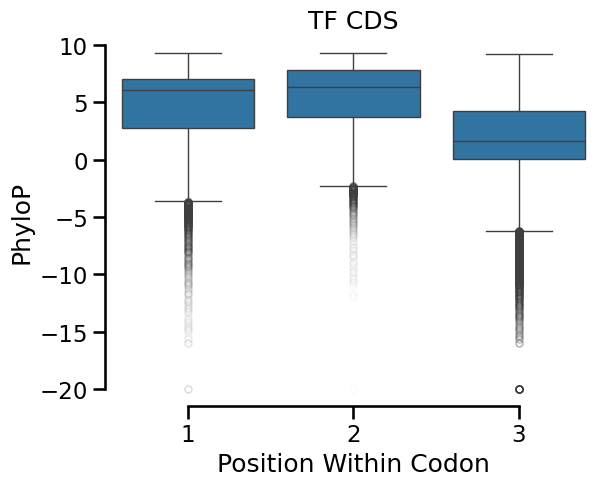

In [47]:
sns.set_context('talk')
#sns.boxplot(data = overlap, x = "codon_pos", y = "PhyloP", fliersize = 0)

#sns.stripplot(data = overlap_df, x = "codon_pos", y = "PhyloP", alpha = 0.25, s = 4, color = "black")

sns.boxplot(
    x="codon_pos",
    y="PhyloP",
    data=overlap_df, flierprops = {'markersize' : 5, 'alpha' : 0.025}
)

plt.xlabel("Position Within Codon")
plt.title("TF CDS")
sns.despine(trim = True)

In [71]:
def plot_mean_desc_boxplot(df):
    sort_order = df[["seq", "PhyloP"]].groupby("seq").median().sort_values(by = "PhyloP", ascending = False).index
    
    sns.set_context('talk')
    #sns.boxplot(data = overlap, x = "codon_pos", y = "PhyloP", fliersize = 0)
    
    #sns.stripplot(data = overlap_df, x = "codon_pos", y = "PhyloP", alpha = 0.25, s = 4, color = "black")
    
    sns.boxplot(
        x="seq",
        y="PhyloP",
        data=df, flierprops = {'markersize' : 5, 'alpha' : 0.025},
        order = sort_order
    )
        
    sns.despine(trim = True)

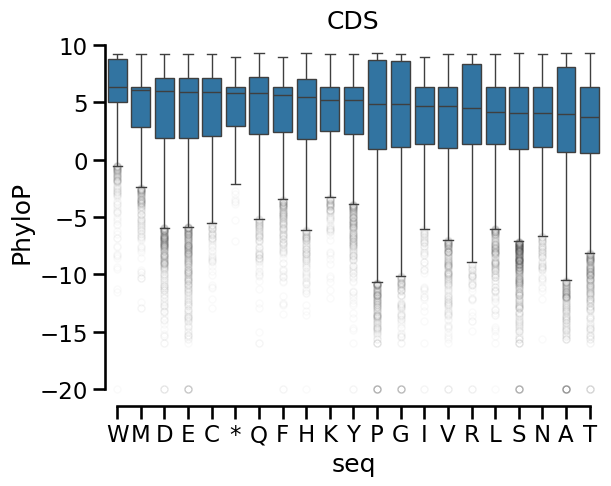

In [72]:
plot_mean_desc_boxplot(overlap_df)
plt.title("CDS");

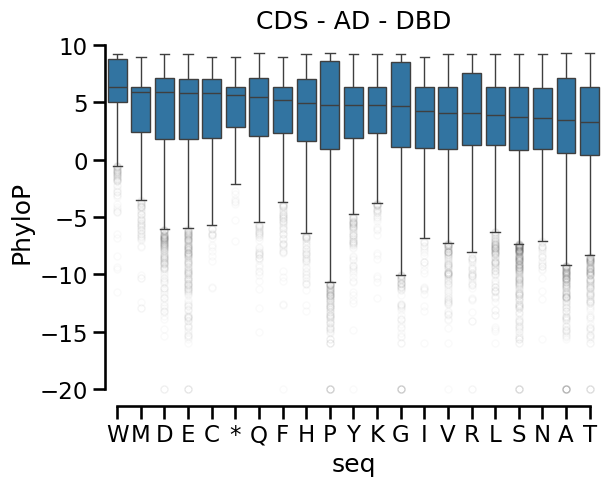

In [76]:
plot_mean_desc_boxplot(overlap_df[(overlap_df[3] != "AD") & (overlap_df[3] != "DBD")])
plt.title("CDS - AD - DBD");

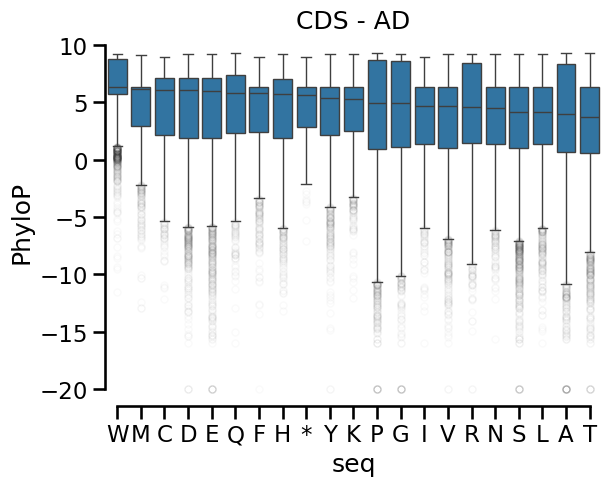

In [73]:
plot_mean_desc_boxplot(overlap_df[overlap_df[3] != "AD"])
plt.title("CDS - AD");

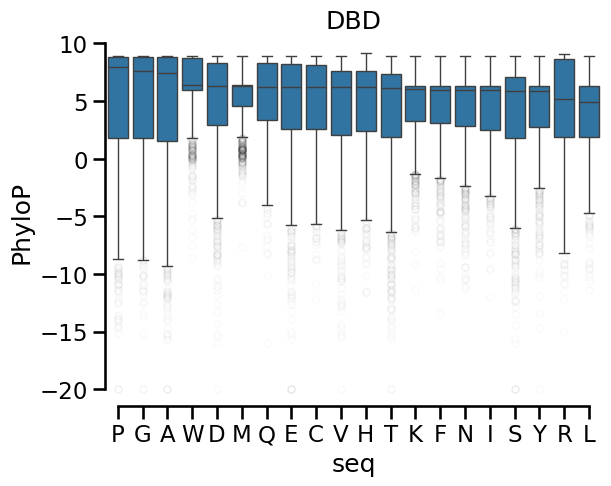

In [74]:
plot_mean_desc_boxplot(overlap_df[overlap_df[3] == "DBD"])
plt.title("DBD");

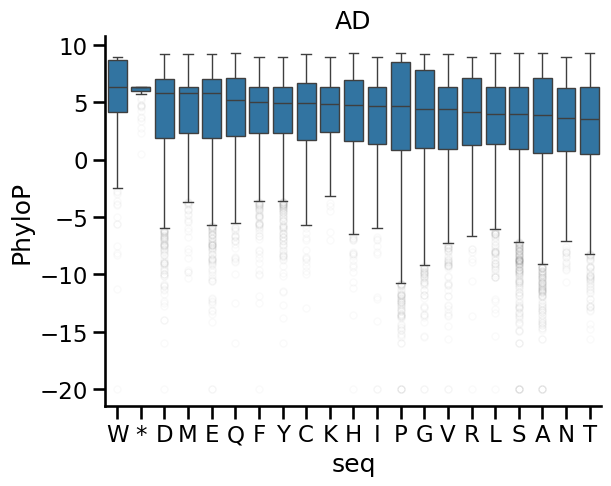

In [52]:
plot_mean_desc_boxplot(overlap_df[overlap_df[3] == "AD"])
plt.title("AD");

In [53]:
overlap_df_pos_1 = overlap_df[overlap_df["codon_pos"] == 1].reset_index(drop = True)
overlap_df_pos_2 = overlap_df[overlap_df["codon_pos"] == 2].reset_index(drop = True)
overlap_df_pos_3 = overlap_df[overlap_df["codon_pos"] == 3].reset_index(drop = True)

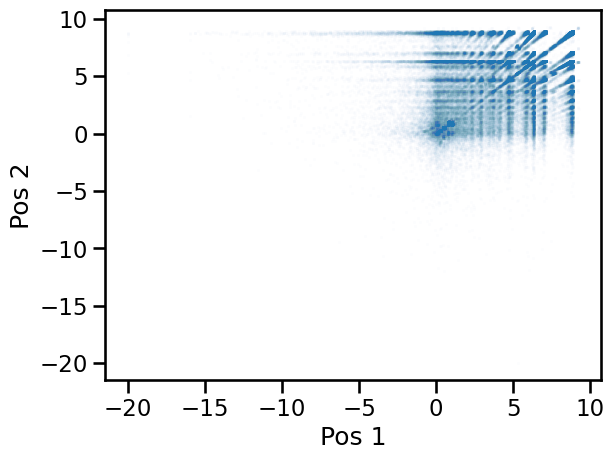

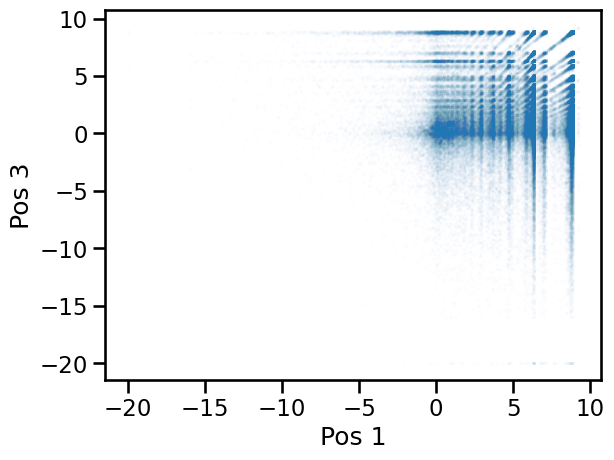

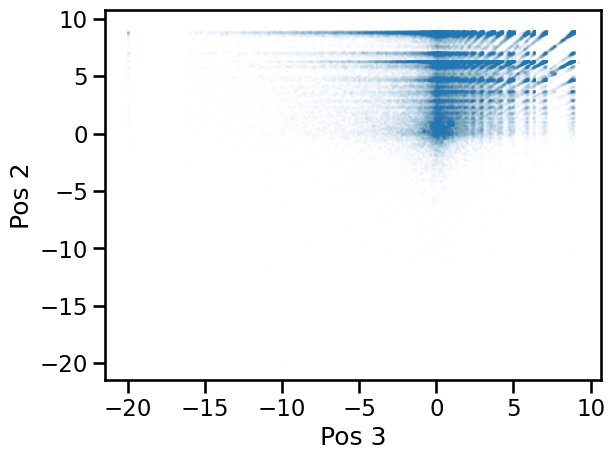

In [54]:
sns.scatterplot(x = overlap_df_pos_1["PhyloP"], y = overlap_df_pos_2["PhyloP"], alpha = 0.01, s = 5)
plt.xlabel("Pos 1")
plt.ylabel("Pos 2")
plt.show();

sns.scatterplot(x = overlap_df_pos_1["PhyloP"], y = overlap_df_pos_3["PhyloP"], alpha = 0.01, s = 5)
plt.xlabel("Pos 1")
plt.ylabel("Pos 3")
plt.show();

sns.scatterplot(x = overlap_df_pos_3["PhyloP"], y = overlap_df_pos_2["PhyloP"], alpha = 0.01, s = 5)
plt.xlabel("Pos 3")
plt.ylabel("Pos 2")
plt.show();

In [55]:
overlap_df_first_2_pos = overlap_df[overlap_df["codon_pos"] < 3]
overlap_df_first_2_pos

,0,all_pos,prot_pos,3,chr,new_start,new_end,seq_split,strand,pos_strand_nt,seq,codon_pos,PhyloP
1,5,77638548,1,NaN,5,77638548,77638549,A,-,T,M,2,6.357
2,5,77638547,1,NaN,5,77638547,77638548,T,-,A,M,1,6.332
4,5,77638545,2,NaN,5,77638545,77638546,C,-,G,L,2,7.030
5,5,77638544,2,NaN,5,77638544,77638545,T,-,A,L,1,6.332
7,5,77638542,3,NaN,5,77638542,77638543,T,-,A,S,2,6.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...
605000,19,3462763,507,AD,19,3462763,3462764,G,+,G,G,1,8.469
605001,19,3462764,508,AD,19,3462764,3462765,G,+,G,G,2,8.469
605003,19,3462766,508,AD,19,3462766,3462767,T,+,T,*,1,6.129
605004,19,3462767,509,NaN,19,3462767,3462768,A,+,A,*,2,3.481


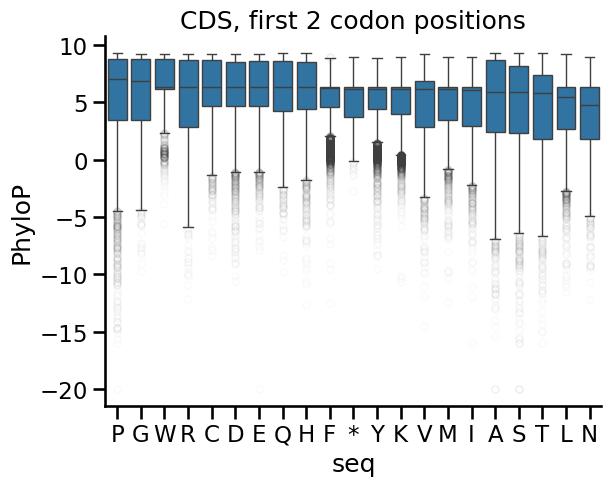

In [56]:
plot_mean_desc_boxplot(overlap_df_first_2_pos)
plt.title("CDS, first 2 codon positions");

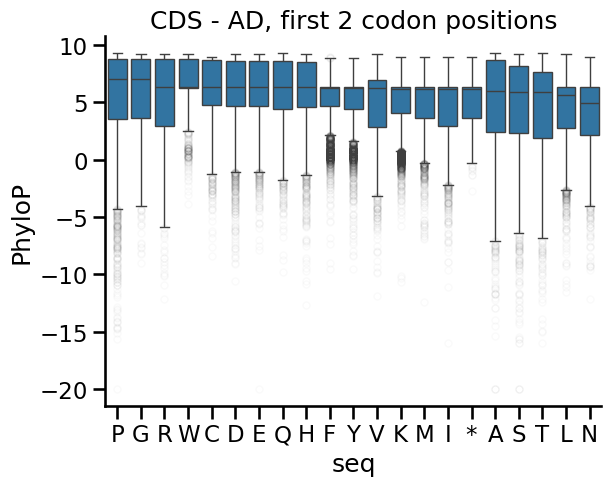

In [57]:
plot_mean_desc_boxplot(overlap_df_first_2_pos[overlap_df_first_2_pos[3] != "AD"])
plt.title("CDS - AD, first 2 codon positions");

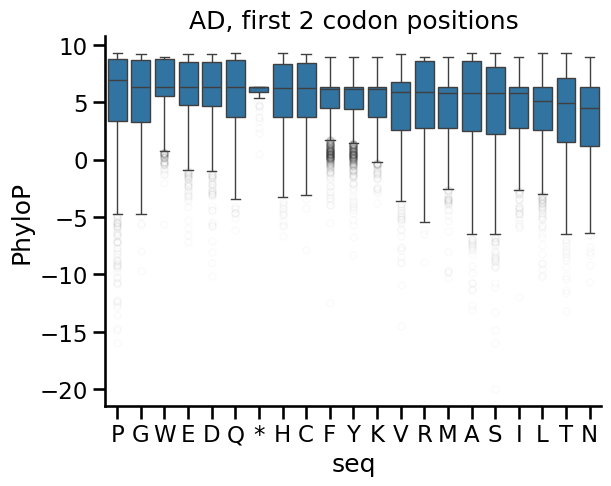

In [58]:
plot_mean_desc_boxplot(overlap_df_first_2_pos[overlap_df_first_2_pos[3] == "AD"])
plt.title("AD, first 2 codon positions");

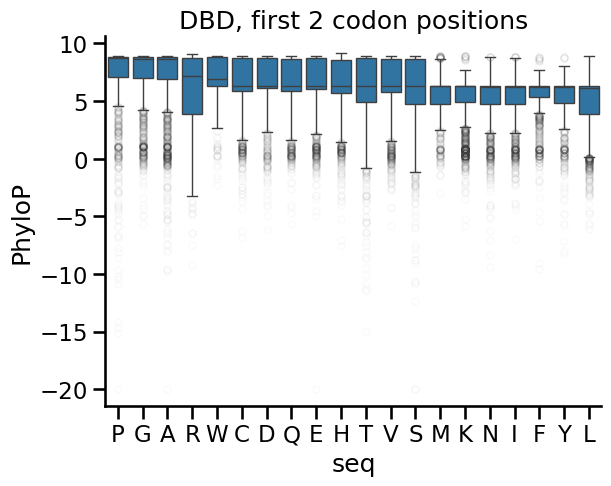

In [59]:
plot_mean_desc_boxplot(overlap_df_first_2_pos[overlap_df_first_2_pos[3] == "DBD"])
plt.title("DBD, first 2 codon positions");

In [60]:
overlap_df_first_2_pos["hue"] = overlap_df_first_2_pos[3].map({np.nan: "CDS - AD", "DBD" : "CDS - AD", "AD" : "AD"})
overlap_df_first_2_pos[3] = overlap_df_first_2_pos[3].fillna("CDS - AD - DBD")
overlap_df_first_2_pos

,0,all_pos,prot_pos,3,chr,new_start,new_end,seq_split,strand,pos_strand_nt,seq,codon_pos,PhyloP,hue
1,5,77638548,1,CDS - AD - DBD,5,77638548,77638549,A,-,T,M,2,6.357,CDS - AD
2,5,77638547,1,CDS - AD - DBD,5,77638547,77638548,T,-,A,M,1,6.332,CDS - AD
4,5,77638545,2,CDS - AD - DBD,5,77638545,77638546,C,-,G,L,2,7.030,CDS - AD
5,5,77638544,2,CDS - AD - DBD,5,77638544,77638545,T,-,A,L,1,6.332,CDS - AD
7,5,77638542,3,CDS - AD - DBD,5,77638542,77638543,T,-,A,S,2,6.332,CDS - AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605000,19,3462763,507,AD,19,3462763,3462764,G,+,G,G,1,8.469,AD
605001,19,3462764,508,AD,19,3462764,3462765,G,+,G,G,2,8.469,AD
605003,19,3462766,508,AD,19,3462766,3462767,T,+,T,*,1,6.129,AD
605004,19,3462767,509,CDS - AD - DBD,19,3462767,3462768,A,+,A,*,2,3.481,CDS - AD


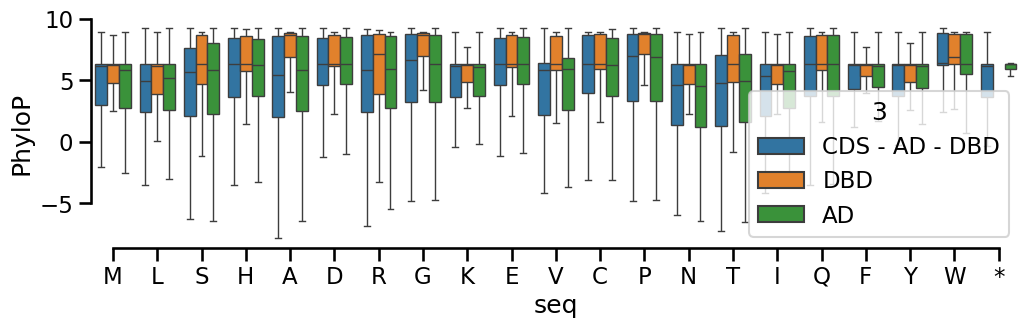

In [61]:
plt.figure(figsize = (12, 3))
sns.boxplot(x="seq", y="PhyloP",
            hue=3,
            data=overlap_df_first_2_pos, showfliers = False)
sns.despine(trim=True)

In [62]:
def plot_paired_mean_desc_boxplot(df, hue):
    sort_order = df[["seq", "PhyloP"]].groupby("seq").median().sort_values(by = "PhyloP", ascending = False).index
    
    sns.set_context('talk')
    #sns.boxplot(data = overlap, x = "codon_pos", y = "PhyloP", fliersize = 0)
    
    #sns.stripplot(data = overlap_df, x = "codon_pos", y = "PhyloP", alpha = 0.25, s = 4, color = "black")
    
    sns.boxplot(
        x="seq",
        y="PhyloP",
        data=df, flierprops = {'markersize' : 5, 'alpha' : 0.025}, hue = hue,
        order = sort_order, showfliers = False
    )
        
    sns.despine()

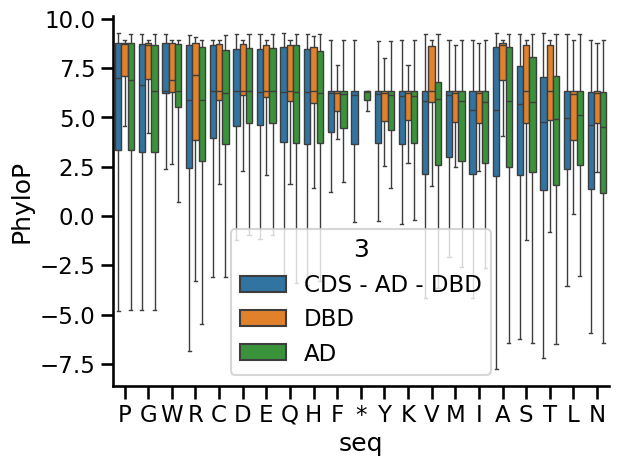

In [63]:
plot_paired_mean_desc_boxplot(overlap_df_first_2_pos, 3)

In [64]:
overlap_df["hue"] = overlap_df[3].map({np.nan: "CDS - AD", "DBD" : "CDS - AD", "AD" : "AD"})
overlap_df[3] = overlap_df[3].fillna("CDS - AD - DBD")
overlap_df

,0,all_pos,prot_pos,3,chr,new_start,new_end,seq_split,strand,pos_strand_nt,seq,codon_pos,PhyloP,hue
0,5,77638549,1,CDS - AD - DBD,NaN,NaN,NaN,NaN,NaN,NaN,M,3,7.128,CDS - AD
1,5,77638548,1,CDS - AD - DBD,5,77638548,77638549,A,-,T,M,2,6.357,CDS - AD
2,5,77638547,1,CDS - AD - DBD,5,77638547,77638548,T,-,A,M,1,6.332,CDS - AD
3,5,77638546,2,CDS - AD - DBD,5,77638546,77638547,G,-,C,L,3,8.899,CDS - AD
4,5,77638545,2,CDS - AD - DBD,5,77638545,77638546,C,-,G,L,2,7.030,CDS - AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605002,19,3462765,508,AD,19,3462765,3462766,A,+,A,G,3,0.049,AD
605003,19,3462766,508,AD,19,3462766,3462767,T,+,T,*,1,6.129,AD
605004,19,3462767,509,CDS - AD - DBD,19,3462767,3462768,A,+,A,*,2,3.481,CDS - AD
605005,19,3462768,509,CDS - AD - DBD,19,3462768,3462769,G,+,G,*,3,1.267,CDS - AD


In [65]:
overlap_df[3].value_counts()

3
CDS - AD - DBD    336715
AD                163867
DBD               104425
Name: count, dtype: int64

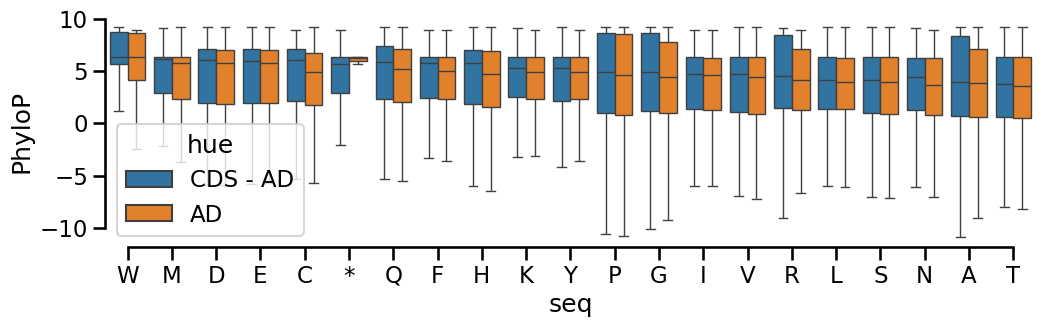

In [70]:
plt.figure(figsize = (12, 3))
plot_paired_mean_desc_boxplot(overlap_df, "hue")
sns.despine(trim = True)

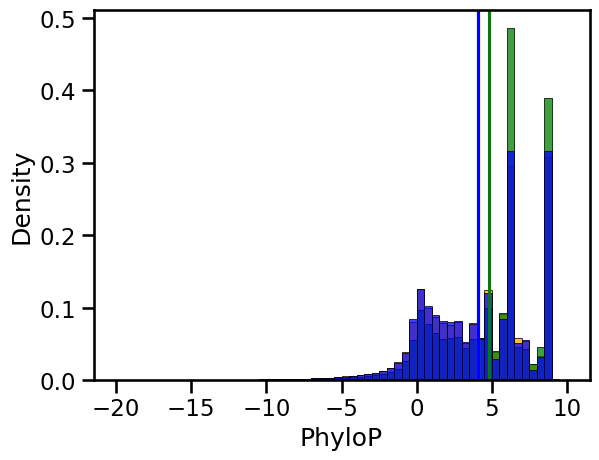

In [67]:
bins = np.arange(-20, 10.1, 0.5)
sns.histplot(overlap_df[overlap_df[3] == "AD"]["PhyloP"], stat = 'density', bins = bins, color = "orange")
plt.axvline(np.mean(overlap_df[overlap_df[3] == "AD"]["PhyloP"]), color = "orange")

sns.histplot(overlap_df[overlap_df[3] == "DBD"]["PhyloP"], stat = 'density', bins = bins, color = "green")
plt.axvline(np.mean(overlap_df[overlap_df[3] == "DBD"]["PhyloP"]), color = "green")

sns.histplot(overlap_df[overlap_df[3] == "CDS - AD - DBD"]["PhyloP"], stat = 'density', bins = bins, color = "blue")
plt.axvline(np.mean(overlap_df[overlap_df[3] == "CDS - AD - DBD"]["PhyloP"]), color = "blue")


In [68]:
overlap_df

,0,all_pos,prot_pos,3,chr,new_start,new_end,seq_split,strand,pos_strand_nt,seq,codon_pos,PhyloP,hue
0,5,77638549,1,CDS - AD - DBD,NaN,NaN,NaN,NaN,NaN,NaN,M,3,7.128,CDS - AD
1,5,77638548,1,CDS - AD - DBD,5,77638548,77638549,A,-,T,M,2,6.357,CDS - AD
2,5,77638547,1,CDS - AD - DBD,5,77638547,77638548,T,-,A,M,1,6.332,CDS - AD
3,5,77638546,2,CDS - AD - DBD,5,77638546,77638547,G,-,C,L,3,8.899,CDS - AD
4,5,77638545,2,CDS - AD - DBD,5,77638545,77638546,C,-,G,L,2,7.030,CDS - AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605002,19,3462765,508,AD,19,3462765,3462766,A,+,A,G,3,0.049,AD
605003,19,3462766,508,AD,19,3462766,3462767,T,+,T,*,1,6.129,AD
605004,19,3462767,509,CDS - AD - DBD,19,3462767,3462768,A,+,A,*,2,3.481,CDS - AD
605005,19,3462768,509,CDS - AD - DBD,19,3462768,3462769,G,+,G,*,3,1.267,CDS - AD


In [42]:
# # Preparing input for API calls
# zoonomia_input[0] = zoonomia_input[0].str[3:]
# zoonomia_input

In [43]:
# # Helper function to make API call

# def return_dna_seq(chr_num, start, end):
#     # Define the endpoint and parameters
#     url = "http://api.genome.ucsc.edu/getData/sequence"
#     params = {
#         "genome" : "hg38",
#         "chrom": "chr" + str(chr_num),
#         "start": start, # So the genome browser is actually 1 off??
#         "end": end
#     }
    
#     # Make the GET request to the UCSC Genome Browser API
#     response = requests.get(url, params=params)
    
#     # Check if the request was successful (status code 200)
#     if response.status_code == 200:
#         # Parse the JSON response (assuming the response is in JSON format)
#         dna_sequence = response.json()
#         # Print the DNA sequence
#         #print('done')
#         return dna_sequence['dna']
#     else:
#         print(str(chr_num))
#         print(start)
#         print(end)
#         print(f"Error: {response.status_code}")
#         return "!"


In [44]:
# # Slow to run! Collecting the DNA sequences for each region

# nts = []
# for i in zoonomia_input.index:
#     if i%10 == 0:
#         print(i)
#     row = zoonomia_input.iloc[i]
#     nts.append(return_dna_seq(row[0], row[1], row[2]))
# zoonomia_input["nt"] = nts
# zoonomia_input    